## Avaliação em holdouts - Amazon Digital Music

In [2]:
import os
import sys
sys.path.append(os.path.abspath('') + '/..')

In [3]:
from data import ImplicitData, getBucketsHoldouts
from plot_utils import lineplot_recallxholdout, recall_heatmap
from dataset_evaluation_utils import *
from recommenders_implicit import ISGD, RAISGD, RSISGD  # ISGD framework, BISGD,
from eval_implicit import EvaluateHoldouts, EvaluateAndStore, EvalPrequential # EvaluateAndStore para guardar estados do modelo e holdouts, a avaliação prequencial de ratings implicitos é opcional, , EvalHoldout

from datetime import datetime
import joblib
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('whitegrid')

___
## BWT FWT

ACC, BWT, e FWT - Lopez-Paz e Ranzato GEM

In [5]:
def avg_recall(results_matrix): # Lopez-Paz e Ranzato GEM 2017
    return np.mean( np.diag(results_matrix) )

def compute_BWT(results_matrix): # Lopez-Paz e Ranzato GEM 2017
    BWT = []
    n_checkpoints = results_matrix.shape[0]
    for T in range(1, n_checkpoints): # 1 means holdout 2, 2 means 3, so on
        Rti = results_matrix.iloc[T, 0:T] # get models performances' on previous holdouts
        Rii = np.diag(results_matrix)[0:T] # get models performances' on their closest holdouts (diagonal)
        E = sum( Rti - Rii ) # future models performances' - performances' of models closest to holdouts (diagonal)
        BWT.append( E/T ) # store average BWT for model
    return BWT, np.mean( BWT ) # return BWT and average BWT for all models

def compute_FWT(results_matrix): # Díaz-Rodriguez et al. 2018
    upper_tri = results_matrix.to_numpy()[np.triu_indices(results_matrix.shape[0], k=1)]
    return np.mean(upper_tri)

___
# Amazon Digital Music
Small subset, ratings only.  
https://nijianmo.github.io/amazon/index.html


In [7]:
# importa dataset 'books playlists'
data = pd.read_csv('output/amazon_digmusic_dump/sampled_amazon_digmusic.csv')
dataset_name = 'Amazon_digital_music'
user_col = 'user_id'
item_col = 'item_id'

In [8]:
data.shape, data.user_id.nunique(), data.item_id.nunique()

((29781, 4), 9991, 21663)

In [9]:
data[['user_id', 'item_id']].duplicated().sum()

2990

In [10]:
data.head()

,user_id,item_id,timestamp,date
0,1932192077,A2YIH1J1C1IAN,1388534400,2014-01-01
1,5557585400,A3LEJBI2BBW9S1,1388534400,2014-01-01
2,5558433892,AQCR49SH6TGL4,1388534400,2014-01-01
3,B00008GSAW,A1TCDA1FGUUKX5,1388534400,2014-01-01
4,B000CKGVNS,A23VR9FQQE933D,1388534400,2014-01-01


In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29781 entries, 0 to 29780
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   user_id    29781 non-null  object
 1   item_id    29781 non-null  object
 2   timestamp  29781 non-null  int64 
 3   date       29781 non-null  object
dtypes: int64(1), object(3)
memory usage: 930.8+ KB


### Convert timestamp

In [12]:
%%time 
# 2.42s
data['date'] = data['date'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))
# data.sort_values(by='timestamp', inplace=True)

CPU times: total: 188 ms
Wall time: 302 ms


In [13]:
data.head()

,user_id,item_id,timestamp,date
0,1932192077,A2YIH1J1C1IAN,1388534400,2014-01-01
1,5557585400,A3LEJBI2BBW9S1,1388534400,2014-01-01
2,5558433892,AQCR49SH6TGL4,1388534400,2014-01-01
3,B00008GSAW,A1TCDA1FGUUKX5,1388534400,2014-01-01
4,B000CKGVNS,A23VR9FQQE933D,1388534400,2014-01-01


CPU times: total: 15.6 ms
Wall time: 99.9 ms


Text(0.5, 1.0, 'interactions per month')

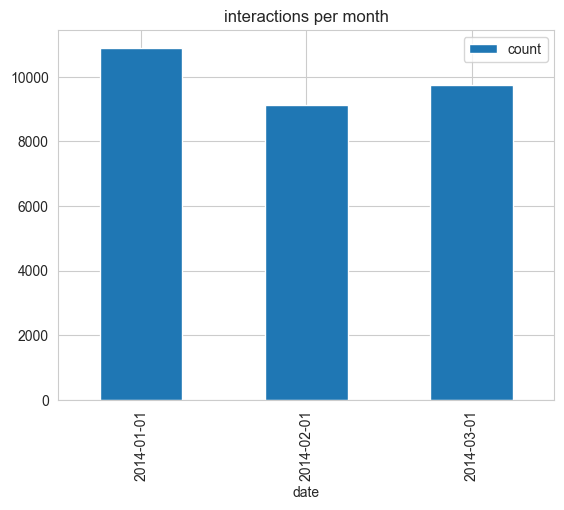

In [14]:
%%time
# 198ms
interactions_per_month = data.groupby(by=['date']).count().iloc[:, 0]
interactions_per_month.name = 'count'
interactions_per_month=interactions_per_month.reset_index()
_ = interactions_per_month.copy()
_['date'] = _['date'].dt.date
_.groupby('date').sum().plot(kind='bar')
plt.title('interactions per month');

___
## Get intervals and Frequent users (threshold = 0.75)

time intervals

In [15]:
user_presence_df = pd.read_csv('output/amazon_digmusic_dump/sample_user_presence_df.csv')
user_month_interactions = pd.read_csv('output/amazon_digmusic_dump/sample_user_month_interactions.csv')
frequent_users_month = joblib.load('output/amazon_digmusic_dump/sample_frequent_users_month.joblib')

___
## Experiments using months

In [16]:
data.shape

(29781, 4)

In [17]:
%%time
# 1min 29s
buckets, holdouts = getBucketsHoldouts(
    data=data,# data[ data['date'].dt.month==1 ],#
    user_col=user_col,
    item_col=item_col,
    frequent_users=data['user_id'].unique(),# frequent_users_month, # for every user in holdout: data['user_id'].unique()
    interval_type='M',
    intervals=None, 
    cold_start_buckets=0)

Creating buckets. . .
Creating holdouts. . .
Cleaning holdouts. . .
common interactions between holdout 1 and all buckets: 739
common interactions between holdout 2 and all buckets: 641
common interactions between holdout 3 and all buckets: 628
Converting to ImplicitData. . .
Done!
CPU times: total: 17.4 s
Wall time: 37 s


In [18]:
sum( [b.size for b in buckets] ) + sum( [h.size for h in holdouts] )

29781

In [19]:
joblib.dump(buckets, 'output/amazon_digmusic_dump/sample_buckets.joblib')
joblib.dump(holdouts, 'output/amazon_digmusic_dump/sample_holdouts.joblib')

['output/amazon_digmusic_dump/sample_holdouts.joblib']

In [20]:
buckets = joblib.load('output/amazon_digmusic_dump/sample_buckets.joblib')
holdouts = joblib.load('output/amazon_digmusic_dump/sample_holdouts.joblib')

In [21]:
[(b.size, len(b.userset), len(b.itemset)) for b in buckets]

[(9522, 5212, 7062), (7114, 3576, 5310), (7241, 3330, 5385)]

In [22]:
[(b.size, len(b.userset), len(b.itemset)) for b in holdouts]

[(1385, 1385, 1283), (2019, 2019, 1847), (2500, 2500, 2285)]

### ISGD

Hyperparameters

In [23]:
%%time
import itertools
def grid_search(model, stream, random_seed = 10, interleaved=10):    
    num_factors = [50, 100, 150, 200]
    num_iter = [1, 2, 5, 8]
    learn_rate = [0.01, 0.05, 0.1, 0.25, 0.5]
    regularization = [0.01, 0.05, 0.1, 0.25, 0.5]
    num_nodes = [1, 2, 4, 8, 16]
    grid = [num_factors, num_iter, learn_rate, regularization, num_nodes]
    grid = list(itertools.product(*grid))
    results = []
    for i, hp in enumerate(grid):
        print(((i*100)/len(grid)), '%')
        empty_stream = ImplicitData([], [])
        nf, ni, lr, reg, nn = hp
        m = model(empty_stream, nf, ni, lr, reg, reg, random_seed)
        e = EvalPrequential(m, stream, metrics = ["Recall@N"])
        result = e.Evaluate(start_eval=0, count=stream.size, interleaved=interleaved)
        results.append( np.mean(result['Recall@N']) )
    return grid, results    

# OPTIONAL FOR NOW
prop = 0.05 # 0.1 #
hp_sample = data.iloc[:round( data.shape[0]*prop )]
stream = ImplicitData(hp_sample[user_col], hp_sample[item_col]) #(data['playlist_id'],data['track_id'])    
grid, results = grid_search(model=ISGD, stream=stream, random_seed=10, interleaved=100 )
len(grid), len(results), max(results) # (243, 243, 0.0026656511805026656)

0.0 %
0.05 %
0.1 %
0.15 %
0.2 %
0.25 %
0.3 %
0.35 %
0.4 %
0.45 %
0.5 %
0.55 %
0.6 %
0.65 %
0.7 %
0.75 %
0.8 %
0.85 %
0.9 %
0.95 %
1.0 %
1.05 %
1.1 %
1.15 %
1.2 %
1.25 %
1.3 %
1.35 %
1.4 %
1.45 %
1.5 %
1.55 %
1.6 %
1.65 %
1.7 %
1.75 %
1.8 %
1.85 %
1.9 %
1.95 %
2.0 %
2.05 %
2.1 %
2.15 %
2.2 %
2.25 %
2.3 %
2.35 %
2.4 %
2.45 %
2.5 %
2.55 %
2.6 %
2.65 %
2.7 %
2.75 %
2.8 %
2.85 %
2.9 %
2.95 %
3.0 %
3.05 %
3.1 %
3.15 %
3.2 %
3.25 %
3.3 %
3.35 %
3.4 %
3.45 %
3.5 %
3.55 %
3.6 %
3.65 %
3.7 %
3.75 %
3.8 %
3.85 %
3.9 %
3.95 %
4.0 %
4.05 %
4.1 %
4.15 %
4.2 %
4.25 %
4.3 %
4.35 %
4.4 %
4.45 %
4.5 %
4.55 %
4.6 %
4.65 %
4.7 %
4.75 %
4.8 %
4.85 %
4.9 %
4.95 %
5.0 %


c:\Users\mjlav\Desktop\work\european_comission\measuring_forgetting\notebooks/..\recommenders_implicit\ISGD.py:112: RuntimeWarning: overflow encountered in multiply
  delta = self.learn_rate * (err * q_i - self.user_regularization * p_u)
c:\Users\mjlav\Desktop\work\european_comission\measuring_forgetting\notebooks/..\recommenders_implicit\ISGD.py:113: RuntimeWarning: invalid value encountered in add
  p_u += delta


5.05 %
5.1 %
5.15 %
5.2 %
5.25 %
5.3 %
5.35 %
5.4 %
5.45 %
5.5 %


c:\Users\mjlav\Desktop\work\european_comission\measuring_forgetting\notebooks/..\recommenders_implicit\ISGD.py:119: RuntimeWarning: overflow encountered in multiply
  delta = self.learn_rate * (err * p_u - self.item_regularization * q_i)


5.55 %
5.6 %
5.65 %
5.7 %
5.75 %
5.8 %
5.85 %
5.9 %
5.95 %
6.0 %
6.05 %
6.1 %
6.15 %
6.2 %
6.25 %
6.3 %
6.35 %
6.4 %
6.45 %
6.5 %
6.55 %
6.6 %
6.65 %
6.7 %
6.75 %
6.8 %
6.85 %
6.9 %
6.95 %
7.0 %
7.05 %
7.1 %
7.15 %
7.2 %
7.25 %
7.3 %
7.35 %
7.4 %
7.45 %
7.5 %
7.55 %
7.6 %
7.65 %
7.7 %
7.75 %
7.8 %
7.85 %
7.9 %
7.95 %
8.0 %
8.05 %
8.1 %
8.15 %
8.2 %
8.25 %
8.3 %
8.35 %
8.4 %
8.45 %
8.5 %
8.55 %
8.6 %
8.65 %
8.7 %
8.75 %
8.8 %
8.85 %
8.9 %
8.95 %
9.0 %
9.05 %
9.1 %
9.15 %
9.2 %
9.25 %
9.3 %
9.35 %
9.4 %
9.45 %
9.5 %
9.55 %
9.6 %
9.65 %
9.7 %
9.75 %
9.8 %
9.85 %
9.9 %
9.95 %
10.0 %
10.05 %
10.1 %
10.15 %
10.2 %
10.25 %
10.3 %
10.35 %
10.4 %
10.45 %
10.5 %
10.55 %
10.6 %
10.65 %
10.7 %
10.75 %
10.8 %
10.85 %
10.9 %
10.95 %
11.0 %
11.05 %
11.1 %
11.15 %
11.2 %
11.25 %


c:\Users\mjlav\Desktop\work\european_comission\measuring_forgetting\notebooks/..\recommenders_implicit\ISGD.py:119: RuntimeWarning: invalid value encountered in subtract
  delta = self.learn_rate * (err * p_u - self.item_regularization * q_i)


11.3 %
11.35 %
11.4 %
11.45 %
11.5 %
11.55 %
11.6 %
11.65 %
11.7 %
11.75 %
11.8 %
11.85 %
11.9 %
11.95 %
12.0 %
12.05 %
12.1 %
12.15 %
12.2 %
12.25 %
12.3 %
12.35 %
12.4 %
12.45 %
12.5 %
12.55 %
12.6 %
12.65 %
12.7 %
12.75 %
12.8 %
12.85 %
12.9 %
12.95 %
13.0 %
13.05 %
13.1 %
13.15 %
13.2 %
13.25 %
13.3 %
13.35 %
13.4 %
13.45 %
13.5 %
13.55 %
13.6 %
13.65 %
13.7 %
13.75 %
13.8 %
13.85 %
13.9 %
13.95 %
14.0 %
14.05 %
14.1 %
14.15 %
14.2 %
14.25 %
14.3 %
14.35 %
14.4 %
14.45 %
14.5 %
14.55 %
14.6 %
14.65 %
14.7 %
14.75 %
14.8 %
14.85 %
14.9 %
14.95 %
15.0 %
15.05 %
15.1 %
15.15 %
15.2 %
15.25 %
15.3 %
15.35 %
15.4 %
15.45 %
15.5 %
15.55 %
15.6 %
15.65 %
15.7 %
15.75 %
15.8 %
15.85 %
15.9 %
15.95 %
16.0 %
16.05 %
16.1 %
16.15 %
16.2 %
16.25 %
16.3 %
16.35 %
16.4 %
16.45 %
16.5 %
16.55 %
16.6 %
16.65 %
16.7 %
16.75 %
16.8 %
16.85 %
16.9 %
16.95 %
17.0 %
17.05 %
17.1 %
17.15 %
17.2 %
17.25 %
17.3 %
17.35 %
17.4 %
17.45 %
17.5 %
17.55 %
17.6 %
17.65 %
17.7 %
17.75 %
17.8 %
17.85 %
17.9 %
17.

(2000, 2000, 0.2222222222222222)

In [24]:
print(  grid[ np.argmax( results ) ] )
# num_factors, num_iter, learn_rate, regularization, num_nodes = grid[ np.argmax( results ) ]
num_factors, num_iter, learn_rate, regularization, num_nodes = grid[ np.argmax( results ) ]

# previous  (100, 5, 0.5, 0.3, 4)

# OLD
# define hyperparameters (SAME AS LASTFM) ????
# num_factors = 160
# num_iter = 4
# learn_rate = 0.5
# regularization = 0.4
# num_nodes = 8

(50, 2, 0.01, 0.01, 4)


In [25]:
# transforma interações em objeto que contem mappings usuário-itens e item-usuários, contém também métodos de suporte. recebe listas
# stream = ImplicitData(data[user_col], data[item_col])
# O modelo deve ser iniciado com uma lista vazia
empty_stream = ImplicitData([], [])
# Se o stream for passado, ao excluir itens conhecidos o recall é sempre 0. Ao permitir a recomendação de itens já vistos, o recall não é 0.
model = ISGD(empty_stream, num_factors, num_iter, learn_rate = learn_rate, u_regularization = regularization, i_regularization = regularization, random_seed = 10)

In [26]:
# criamos instancia de EvaluateHoldouts para treinar o modelo e criar checkpoints
eval = EvaluateHoldouts(model=model, buckets=buckets, holdouts=holdouts)

In [27]:
%%time
# 1h 27min 10s
eval.Train_Evaluate(N_recommendations=20, exclude_known_items=True, default_user='none')

----------------------------------------------------------------------------------------------------
Train bucket 0


Test Holdout 0
Test Holdout 1
recommendations not made for users in holdout 1 x checkpoint 0: 411
Test Holdout 2
recommendations not made for users in holdout 2 x checkpoint 0: 958
----------------------------------------------------------------------------------------------------
Train bucket 1
Test Holdout 0
Test Holdout 1
Test Holdout 2
recommendations not made for users in holdout 2 x checkpoint 1: 343
----------------------------------------------------------------------------------------------------
Train bucket 2
Test Holdout 0
Test Holdout 1
Test Holdout 2
CPU times: total: 4min 39s
Wall time: 8min 16s


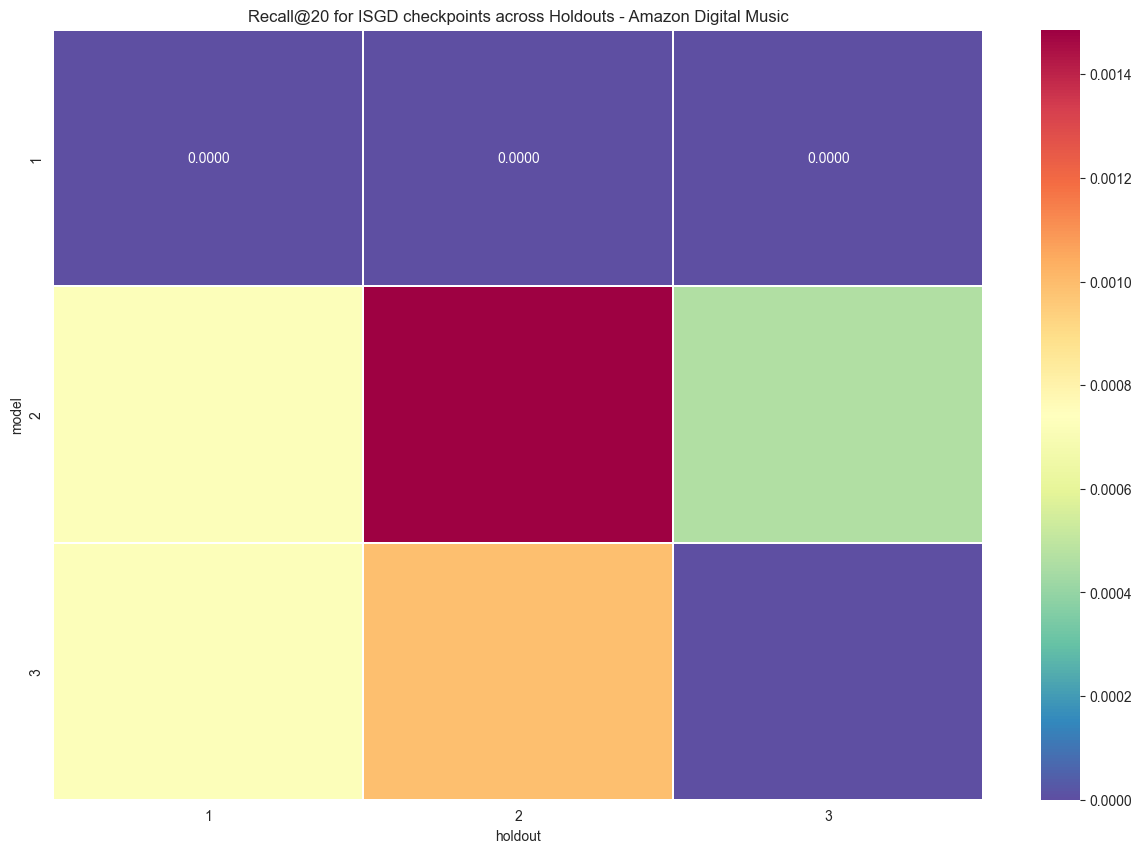

In [29]:
rm = eval.results_matrix
df = pd.DataFrame(rm)
df.to_csv('output/amazon_digmusic_dump/sample_amazon_digital_music month_bucket ISGD results.csv', index=False)

recall_heatmap(df,
    round_point=4,
    title='Recall@20 for ISGD checkpoints across Holdouts - Amazon Digital Music',
    filepath='images/heatmaps/amazon_digmusic_dump/sample_amazon_digital_music month_bucket ISGD heatmap.png') #='images/heatmaps/palco_2010 month_bucket ISGD heatmap.png'

In [30]:
arecall = avg_recall(df)
arecall

0.0004952947003467063

In [31]:
BWT, meanBWT = compute_BWT(df)
BWT, meanBWT

([0.0007220216606498195, 0.0001133634801515566], 0.00041769257040068805)

In [32]:
FWT = compute_FWT(df)
FWT
# que itens que usuario utilizou no passado e deixou de consumir o sistema ainda pode recomendar

0.00015453562046051613

In [33]:
joblib.dump(eval.IncrementalTraining_time_record, 'output/amazon_digmusic_dump/sample_amazon_digmusic month_bucket ISGD training time.joblib')
joblib.dump(eval.EvaluateHoldouts_time_record, 'output/amazon_digmusic_dump/sample_amazon_digmusic month_bucket ISGD eval time.joblib')

['output/amazon_digmusic_dump/sample_amazon_digmusic month_bucket ISGD eval time.joblib']

In [34]:
import pandas as pd
import numpy as np

def avg_recall(results_matrix):
    return np.mean( np.diag(results_matrix) )

def compute_BWT(results_matrix): # Díaz-Rodriguez et al. 2018
    diff = []
    n_checkpoints = results_matrix.shape[0]
    for i in range(1, n_checkpoints): # 1 means holdout 2, 2 means 3, so on
        for j in range(i):
            Rij = results_matrix.iloc[i,j] # get models performances' on previous holdouts
            Rjj = results_matrix.iloc[j,j] # get models performances' on their closest holdouts (diagonal)
            # print(Rij, Rjj)
            diff.append( Rij - Rjj ) # future models performances' - performances' of models closest to holdouts (diagonal)
            # print(diff)
    BWT = sum(diff) / ( n_checkpoints*(n_checkpoints-1) / 2 ) # store average BWT for model
    return BWT, diff # return BWT and average BWT for all models

def compute_FWT(results_matrix): # Díaz-Rodriguez et al. 2018
    upper_tri = results_matrix.to_numpy()[np.triu_indices(results_matrix.shape[0], k=1)]
    return np.mean(upper_tri)

In [4]:
df = pd.read_csv('output/amazon_digmusic_dump/sample_amazon_digital_music month_bucket ISGD results.csv')

In [5]:
df

,0,1,2
0,0.000000,0.000000,0.000000
1,0.000722,0.001486,0.000464
2,0.000722,0.000991,0.000000


In [36]:
avg_recall(df).round(5)

0.0005

In [37]:
BWT, diff = compute_BWT(df)
BWT.round(6)

0.000316

In [38]:
compute_FWT(df)

0.0001545356204605161